In [5]:
!unzip -q /content/traffic_wala_dataset.zip

replace traffic_wala_dataset/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This file centralizes all configurable parameters, including file paths, model hyperparameters, and training settings.

In [1]:
%%writefile config.py

import torch
import os

# --- Paths (Set these manually) ---
TRAIN_IMG_DIR = "/content/traffic_wala_dataset/train/images/"
TRAIN_LABEL_DIR = "/content/traffic_wala_dataset/train/labels/"
VALID_IMG_DIR = "/content/traffic_wala_dataset/valid/images/"
VALID_LABEL_DIR = "/content/traffic_wala_dataset/valid/labels/"

# Checkpoints saved to your Google Drive
DRIVE_CHECKPOINT_PATH = "/content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/"
CHECKPOINT_DIR = DRIVE_CHECKPOINT_PATH

# --- Model & Data Configuration ---
INPUT_WIDTH = 480
INPUT_HEIGHT = 320
SEQUENCE_LENGTH = 5
SIGMA = 4.0

# --- Training Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
BATCH_SIZE = 4 # Reduce batch size slightly as metric calculation can use memory
NUM_EPOCHS = 20

# --- NEW: Metric Calculation Configuration ---
PEAK_CONFIDENCE_THRESH = 0.2  # Minimum peak value to be considered a detection
FIXED_BOX_WIDTH = 40          # Width of the pseudo-bounding box in pixels
FIXED_BOX_HEIGHT = 40         # Height of the pseudo-bounding box in pixels

Overwriting config.py


This file defines the neural network architecture, including the custom ConvLSTMCell and the main FCNrLSTM model.


In [2]:
%%writefile model.py

import torch
import torch.nn as nn
from torchvision.models import vgg16
import torch.nn.functional as F

# 1. The custom Convolutional LSTM Cell
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,
                              kernel_size=kernel_size,
                              padding=padding,
                              bias=bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i, f, o, g = torch.sigmoid(cc_i), torch.sigmoid(cc_f), torch.sigmoid(cc_o), torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# 2. The main FCN-rLSTM Model
class FCNrLSTM(nn.Module):
    def __init__(self, hidden_dim=128, lstm_kernel_size=(3, 3)):
        super(FCNrLSTM, self).__init__()
        vgg = vgg16(pretrained=True)
        self.fcn = nn.Sequential(*list(vgg.features.children())[:30])
        self.conv_lstm = ConvLSTMCell(input_dim=512, hidden_dim=hidden_dim, kernel_size=lstm_kernel_size)
        self.regressor = nn.Conv2d(in_channels=hidden_dim, out_channels=1, kernel_size=1)

    def forward(self, x):
        batch_size, seq_len, _, h, w = x.size()
        h_state, c_state = self.conv_lstm.init_hidden(batch_size, (h // 16, w // 16))

        for t in range(seq_len):
            fcn_output = self.fcn(x[:, t, :, :, :])
            h_state, c_state = self.conv_lstm(fcn_output, (h_state, c_state))

        density_map = self.regressor(h_state)
        density_map = F.interpolate(density_map, size=(h, w), mode='bilinear', align_corners=False)
        return density_map

Overwriting model.py


This file defines the custom PyTorch Dataset for loading image sequences and generating their corresponding ground-truth density maps on the fly. It returns the image sequence, the target map, and the label file path for evaluation.


In [3]:
%%writefile dataset.py

import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import config

# create_density_map function remains the same
def create_density_map(points, height, width, sigma):
    density_map = np.zeros((height, width), dtype=np.float32)
    for cx, cy in points:
        x, y = np.ogrid[0:height, 0:width]
        cy_clamped, cx_clamped = min(max(0, cy), height - 1), min(max(0, cx), width - 1)
        g = np.exp(-((x - cy_clamped)**2 + (y - cx_clamped)**2) / (2 * sigma**2))
        density_map += g
    return density_map

class VehicleSequenceDataset(Dataset):
    def __init__(self, img_dir, label_dir):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.seq_len = config.SEQUENCE_LENGTH
        self.frames = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.frames) - self.seq_len + 1

    def __getitem__(self, index):
        target_frame_name = self.frames[index + self.seq_len - 1]

        sequence = []
        for i in range(self.seq_len):
            frame_name = self.frames[index + i]
            img_path = os.path.join(self.img_dir, frame_name)
            image = Image.open(img_path).convert("RGB").resize((config.INPUT_WIDTH, config.INPUT_HEIGHT))
            sequence.append(F.to_tensor(image))
        sequence_tensor = torch.stack(sequence)

        label_path = os.path.join(self.label_dir, target_frame_name.replace(".jpg", ".txt"))
        points = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f.readlines():
                    _, cx, cy, _, _ = [float(x) for x in line.strip().split()]
                    points.append((cx * config.INPUT_WIDTH, cy * config.INPUT_HEIGHT))

        density_map = create_density_map(points, config.INPUT_HEIGHT, config.INPUT_WIDTH, config.SIGMA)

        # --- CHANGE: Return the label path for metric calculation ---
        return sequence_tensor, torch.from_numpy(density_map).unsqueeze(0), label_path

Overwriting dataset.py


This utility file contains the logic for the evaluation workaround: finding peaks in the density map and converting them, along with ground-truth labels, into bounding box formats that torchmetrics can understand.


In [4]:
%%writefile metrics_utils.py

import torch
import torch.nn.functional as F
import numpy as np
import config
import os

def find_peaks(heatmap):
    """Find local peaks in a heatmap."""
    # Use max pooling as a simple form of non-maximum suppression
    peak_map = F.max_pool2d(heatmap, kernel_size=3, stride=1, padding=1)
    # A point is a peak if it's equal to the max in its neighborhood and above threshold
    peaks = (heatmap == peak_map) & (heatmap > config.PEAK_CONFIDENCE_THRESH)
    # The original return value was peaks.squeeze(). This was the source of the bug.
    # By not squeezing, we keep the batch dimension, ensuring nonzero gives 3D coords.
    return peaks

def density_map_to_boxes(density_map_tensor, gt_label_path):
    """
    Converts a density map to pseudo-bounding boxes and loads ground truth boxes.
    """
    # 1. Get predicted boxes from the density map
    # We pass the unsqueezed map to find_peaks
    peaks = find_peaks(density_map_tensor.unsqueeze(0))
    # torch.nonzero on a 3D tensor (Batch, H, W) will return [index, row, col]
    peak_coords = torch.nonzero(peaks, as_tuple=False)

    pred_boxes = []
    pred_scores = []

    H, W = config.INPUT_HEIGHT, config.INPUT_WIDTH
    box_h, box_w = config.FIXED_BOX_HEIGHT, config.FIXED_BOX_WIDTH

    for coord in peak_coords:
        # The coordinates from nonzero will be [batch_idx, y, x]
        # Since our batch size for validation is 1, batch_idx is always 0.
        # y is at coord[1], x is at coord[2].
        cy, cx = coord[1].item(), coord[2].item() # <-- THIS LINE IS NOW CORRECT

        # Get confidence score from the original map
        score = density_map_tensor[cy, cx].item() # We use the 2D map here
        pred_scores.append(score)

        # Create a fixed-size box [xmin, ymin, xmax, ymax]
        xmin = max(0, cx - box_w / 2)
        ymin = max(0, cy - box_h / 2)
        xmax = min(W, cx + box_w / 2)
        ymax = min(H, cy + box_h / 2)
        pred_boxes.append([xmin, ymin, xmax, ymax])

    # 2. Get ground truth boxes from the label file
    gt_boxes = []
    if os.path.exists(gt_label_path):
        with open(gt_label_path) as f:
            for line in f.readlines():
                _, cx, cy, w, h = [float(x) for x in line.strip().split()]
                # Convert from [center, size] to [xmin, ymin, xmax, ymax]
                xmin = (cx - w / 2) * W
                ymin = (cy - h / 2) * H
                xmax = (cx + w / 2) * W
                ymax = (cy + h / 2) * H
                gt_boxes.append([xmin, ymin, xmax, ymax])

    return torch.tensor(pred_boxes), torch.tensor(pred_scores), torch.tensor(gt_boxes)

Overwriting metrics_utils.py


This is the main script that orchestrates the entire training and validation process. It initializes the model, loss function, and optimizer, then loops through epochs, performing a training step followed by a validation step where mAP/mAR are calculated.


In [8]:
%%writefile train.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision # Import the metric

# Import our custom modules
import config
from model import FCNrLSTM
from dataset import VehicleSequenceDataset
from metrics_utils import density_map_to_boxes

def main():
    # os.makedirs(config.CHECKPOINT_DIR, exist_ok=True) # This might cause an error if /content/drive is not mounted.
    # We will create it only when we save the model to avoid this.

    model = FCNrLSTM().to(config.DEVICE)
    loss_fn = nn.MSELoss().to(config.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    # --- Dataloaders ---
    train_dataset = VehicleSequenceDataset(config.TRAIN_IMG_DIR, config.TRAIN_LABEL_DIR)
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    val_dataset = VehicleSequenceDataset(config.VALID_IMG_DIR, config.VALID_LABEL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True) # Use batch_size=1 for metric calculation

    print(f"Starting training on {config.DEVICE}...")
    best_val_map = 0.0

    for epoch in range(config.NUM_EPOCHS):
        # --- Training Phase ---
        model.train()
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{config.NUM_EPOCHS}] Training")
        for sequences, target_maps, _ in train_loop: # Ignore label path during training
            sequences, target_maps = sequences.to(config.DEVICE), target_maps.to(config.DEVICE)
            predicted_maps = model(sequences)
            loss = loss_fn(predicted_maps, target_maps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loop.set_postfix(loss=loss.item())

        # --- Validation Phase with mAP/mAR ---
        model.eval()
        # Initialize the metric object
        metric = MeanAveragePrecision(box_format='xyxy')

        val_loop = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for sequences, target_maps, label_paths in val_loop:
                sequences = sequences.to(config.DEVICE)
                predicted_map = model(sequences).squeeze() # Squeeze to get single map

                # We process one image at a time (batch_size=1)
                label_path = label_paths[0]

                # Convert density map to boxes
                pred_boxes, pred_scores, gt_boxes = density_map_to_boxes(predicted_map.cpu(), label_path)

                # --- THIS IS THE FIX ---
                # Format for torchmetrics, ensuring labels are integers (torch.long)
                preds = [dict(boxes=pred_boxes, scores=pred_scores, labels=torch.zeros(len(pred_scores), dtype=torch.long))]
                target = [dict(boxes=gt_boxes, labels=torch.zeros(len(gt_boxes), dtype=torch.long))]

                # Update the metric with predictions and targets for this image
                metric.update(preds, target)

        # Compute and print the final metrics for the epoch
        results = metric.compute()
        map_50 = results['map_50'].item()
        mar_100 = results['mar_100'].item()

        print(f"Epoch {epoch+1} Summary: mAP@.50 = {map_50:.4f} | mAR@100 = {mar_100:.4f}")

        # Save the best model based on mAP
        if map_50 > best_val_map:
            best_val_map = map_50
            os.makedirs(config.CHECKPOINT_DIR, exist_ok=True) # Create dir only when saving
            best_model_path = os.path.join(config.CHECKPOINT_DIR, "best_model_map.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path} with mAP@.50: {best_val_map:.4f}")

if __name__ == "__main__":
    main()

Overwriting train.py


In [6]:
pip install torchmetrics

In [9]:
%run train.py

Starting training on cuda...


Epoch [1/20] Training: 100%|██████████| 133/133 [02:28<00:00,  1.12s/it, loss=0.003]


Epoch 1 Summary: mAP@.50 = 0.0025 | mAR@100 = 0.0012
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0025


Epoch [2/20] Training: 100%|██████████| 133/133 [02:26<00:00,  1.10s/it, loss=0.000981]


Epoch 2 Summary: mAP@.50 = 0.0522 | mAR@100 = 0.0300
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0522


Epoch [3/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.0032]


Epoch 3 Summary: mAP@.50 = 0.0723 | mAR@100 = 0.0489
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0723


Epoch [4/20] Training: 100%|██████████| 133/133 [02:26<00:00,  1.11s/it, loss=0.00161]


Epoch 4 Summary: mAP@.50 = 0.0777 | mAR@100 = 0.0551
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0777


Epoch [5/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00306]


Epoch 5 Summary: mAP@.50 = 0.0815 | mAR@100 = 0.0583
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0815


Epoch [6/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00317]


Epoch 6 Summary: mAP@.50 = 0.0852 | mAR@100 = 0.0609
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0852


Epoch [7/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00234]


Epoch 7 Summary: mAP@.50 = 0.0894 | mAR@100 = 0.0638
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0894


Epoch [8/20] Training: 100%|██████████| 133/133 [02:26<00:00,  1.11s/it, loss=0.00178]


Epoch 8 Summary: mAP@.50 = 0.0903 | mAR@100 = 0.0672
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0903


Epoch [9/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00147]


Epoch 9 Summary: mAP@.50 = 0.0959 | mAR@100 = 0.0677
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.0959


Epoch [10/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00257]


Epoch 10 Summary: mAP@.50 = 0.0922 | mAR@100 = 0.0700


Epoch [11/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00155]


Epoch 11 Summary: mAP@.50 = 0.0943 | mAR@100 = 0.0700


Epoch [12/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00189]


Epoch 12 Summary: mAP@.50 = 0.0925 | mAR@100 = 0.0718


Epoch [13/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00181]


Epoch 13 Summary: mAP@.50 = 0.0956 | mAR@100 = 0.0711


Epoch [14/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00212]


Epoch 14 Summary: mAP@.50 = 0.0935 | mAR@100 = 0.0736


Epoch [15/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.0011]


Epoch 15 Summary: mAP@.50 = 0.0905 | mAR@100 = 0.0730


Epoch [16/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00183]


Epoch 16 Summary: mAP@.50 = 0.0941 | mAR@100 = 0.0730


Epoch [17/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00166]


Epoch 17 Summary: mAP@.50 = 0.0922 | mAR@100 = 0.0740


Epoch [18/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00131]


Epoch 18 Summary: mAP@.50 = 0.0957 | mAR@100 = 0.0727


Epoch [19/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.000695]


Epoch 19 Summary: mAP@.50 = 0.0942 | mAR@100 = 0.0733


Epoch [20/20] Training: 100%|██████████| 133/133 [02:27<00:00,  1.11s/it, loss=0.00215]


Epoch 20 Summary: mAP@.50 = 0.1019 | mAR@100 = 0.0758
New best model saved to /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth with mAP@.50: 0.1019


After training, this script is used to visualize the model's performance. It loads the best-saved model, runs it on random validation samples, and plots the original image, the ground-truth map, the predicted map, and an overlay of detected vehicle locations side-by-side. It also prints the ground-truth vs. predicted counts.


In [12]:
%%writefile visualize.py

import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Import our custom modules
import config
from model import FCNrLSTM
from dataset import VehicleSequenceDataset
from metrics_utils import find_peaks

# --- Configuration ---
MODEL_PATH = os.path.join(config.CHECKPOINT_DIR, "best_model_map.pth")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_IMAGES_TO_SHOW = 5 # How many random images to visualize

def get_gt_count(label_path):
    """Reads a label file and counts the number of lines (objects)."""
    if not os.path.exists(label_path):
        return 0
    with open(label_path, 'r') as f:
        return len(f.readlines())

def load_model(model_path, device):
    """Loads a trained model from a checkpoint file."""
    print(f"Loading model from: {model_path}")
    model = FCNrLSTM().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def visualize_predictions(model, dataset, num_images):
    """
    Picks random images, runs the model, plots results, and prints counts.
    """
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize.")
        return

    sample_indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    for idx in sample_indices:
        # 1. Get data from the dataset
        sequence_tensor, gt_map_tensor, label_path = dataset[idx]
        target_image_tensor = sequence_tensor[-1]

        # 2. Prepare tensors
        input_tensor = sequence_tensor.unsqueeze(0).to(DEVICE)
        target_image_np = target_image_tensor.permute(1, 2, 0).cpu().numpy()
        gt_map_np = gt_map_tensor.squeeze().cpu().numpy()

        # 3. Run model inference
        with torch.no_grad():
            predicted_map_tensor = model(input_tensor)

        predicted_map_np = predicted_map_tensor.squeeze().cpu().numpy()

        # 4. Find peaks and calculate PREDICTED COUNT
        peaks_tensor = find_peaks(predicted_map_tensor)
        peak_coords = torch.nonzero(peaks_tensor, as_tuple=False)
        predicted_count = peak_coords.shape[0]

        # 5. Get GROUND TRUTH COUNT
        gt_count = get_gt_count(label_path)

        # An alternative for GT count is summing the map, but it's an estimate.
        # gt_count_from_map = int(round(gt_map_np.sum()))

        # 6. Create the plots
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))

        # --- ADD COUNTS TO THE TITLE ---
        title = (f"Sample Index: {idx} | "
                 f"Ground Truth Count: {gt_count} | "
                 f"Predicted Count: {predicted_count}")
        fig.suptitle(title, fontsize=16)

        # Plot 1: Original Image
        axs[0].imshow(target_image_np)
        axs[0].set_title("Original Target Image")
        axs[0].axis('off')

        # Plot 2: Overlay with Predicted Peaks
        axs[1].imshow(target_image_np)
        axs[1].set_title("Overlay: Predicted Peaks")
        if peak_coords.numel() > 0:
            y_coords = peak_coords[:, 1].cpu().numpy()
            x_coords = peak_coords[:, 2].cpu().numpy()
            axs[1].scatter(x_coords, y_coords, color='red', s=15, marker='x', label='Predicted')
        axs[1].axis('off')

        # Plot 3: Ground Truth Density Map
        im2 = axs[2].imshow(gt_map_np, cmap='jet')
        axs[2].set_title(f"Ground Truth Density (Sum={gt_map_np.sum():.2f})")
        axs[2].axis('off')

        # Plot 4: Predicted Density Map
        im3 = axs[3].imshow(predicted_map_np, cmap='jet')
        axs[3].set_title(f"Predicted Density (Sum={predicted_map_np.sum():.2f})")
        axs[3].axis('off')

        fig.colorbar(im2, ax=axs[2], orientation='vertical', fraction=0.046, pad=0.04)
        fig.colorbar(im3, ax=axs[3], orientation='vertical', fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

if __name__ == '__main__':
    if "drive" in MODEL_PATH and not os.path.exists("/content/drive"):
        print("Google Drive not mounted. Please mount it to access the model checkpoint.")
    elif not os.path.exists(MODEL_PATH):
        print(f"Model checkpoint not found at: {MODEL_PATH}")
        print("Please ensure the path is correct and the model has been trained.")
    else:
        model = load_model(MODEL_PATH, DEVICE)
        val_dataset = VehicleSequenceDataset(config.VALID_IMG_DIR, config.VALID_LABEL_DIR)
        visualize_predictions(model, val_dataset, NUM_IMAGES_TO_SHOW)

Overwriting visualize.py


Loading model from: /content/drive/MyDrive/Colab Notebooks/VehicleCounting/checkpoints/best_model_map.pth


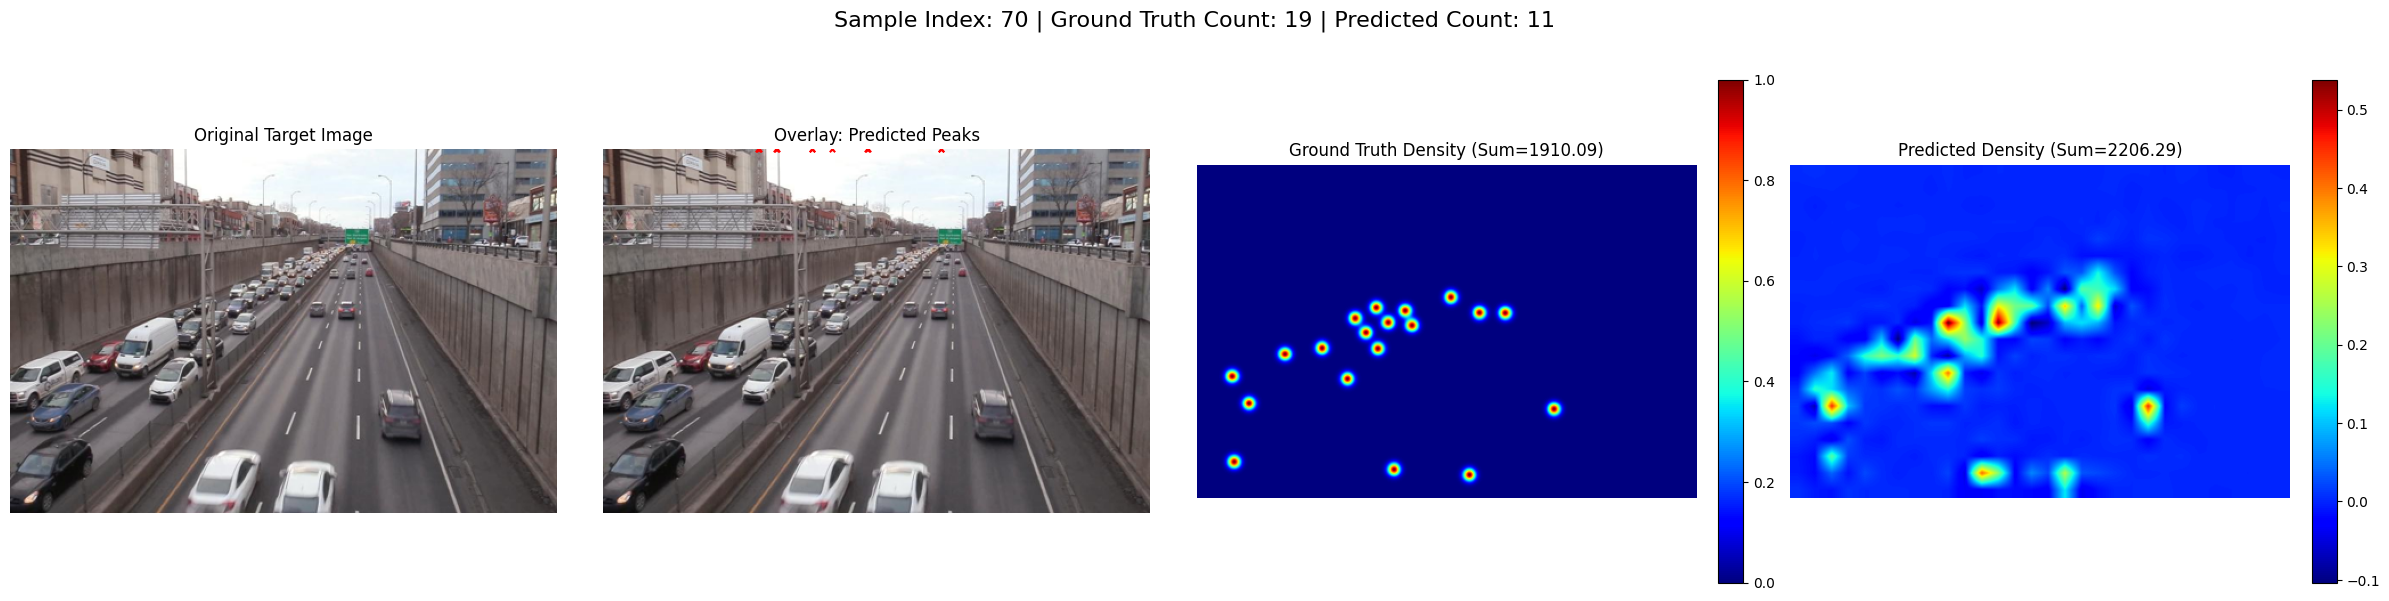

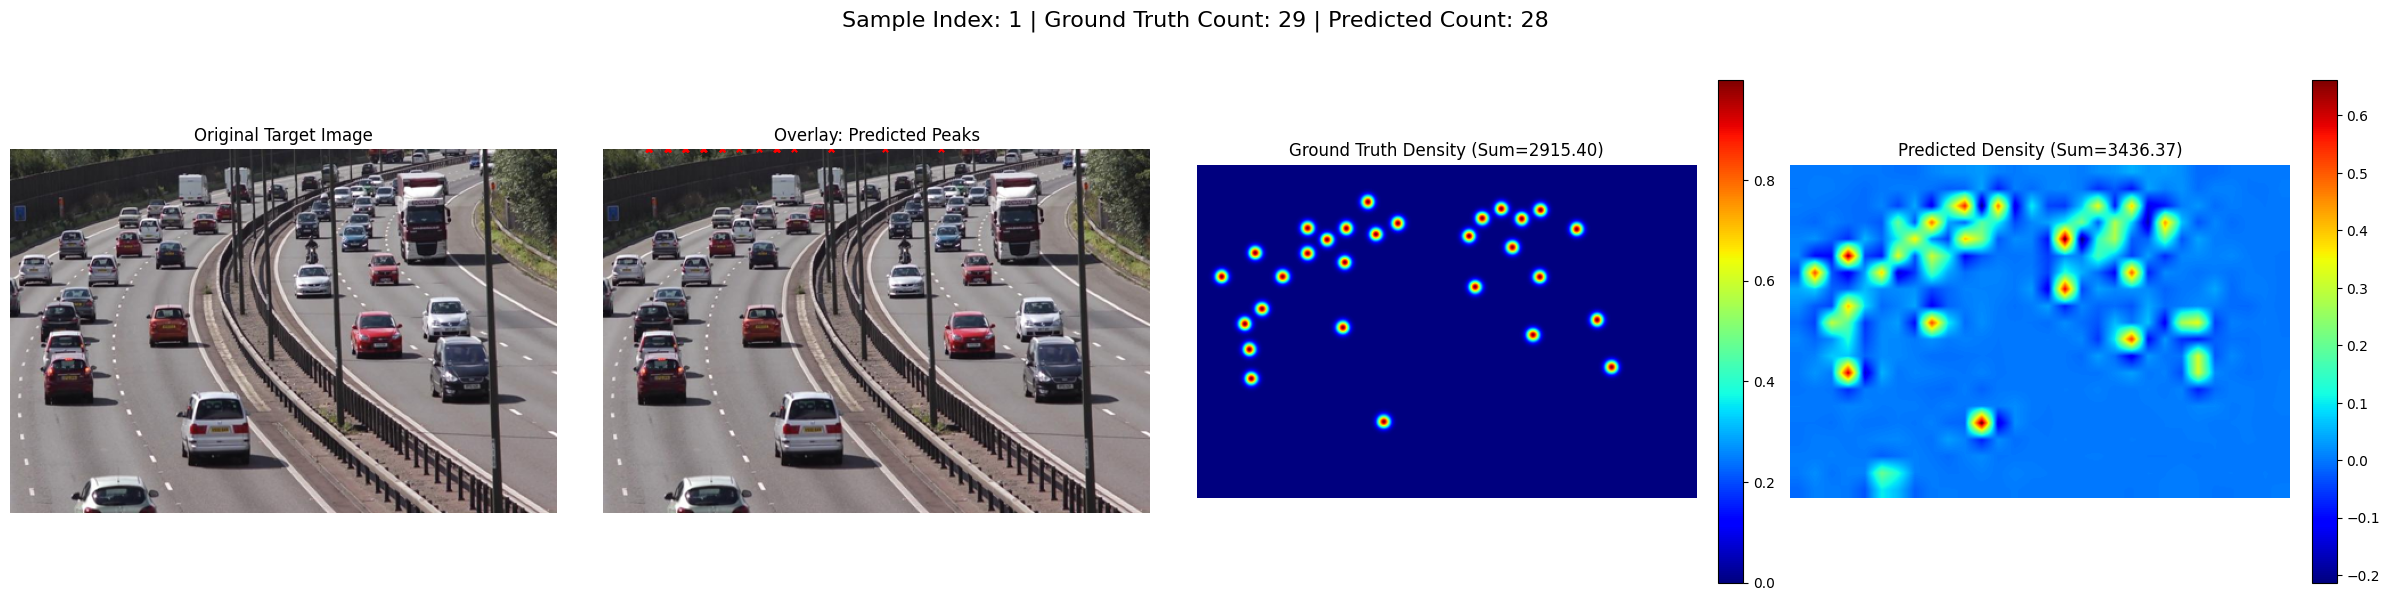

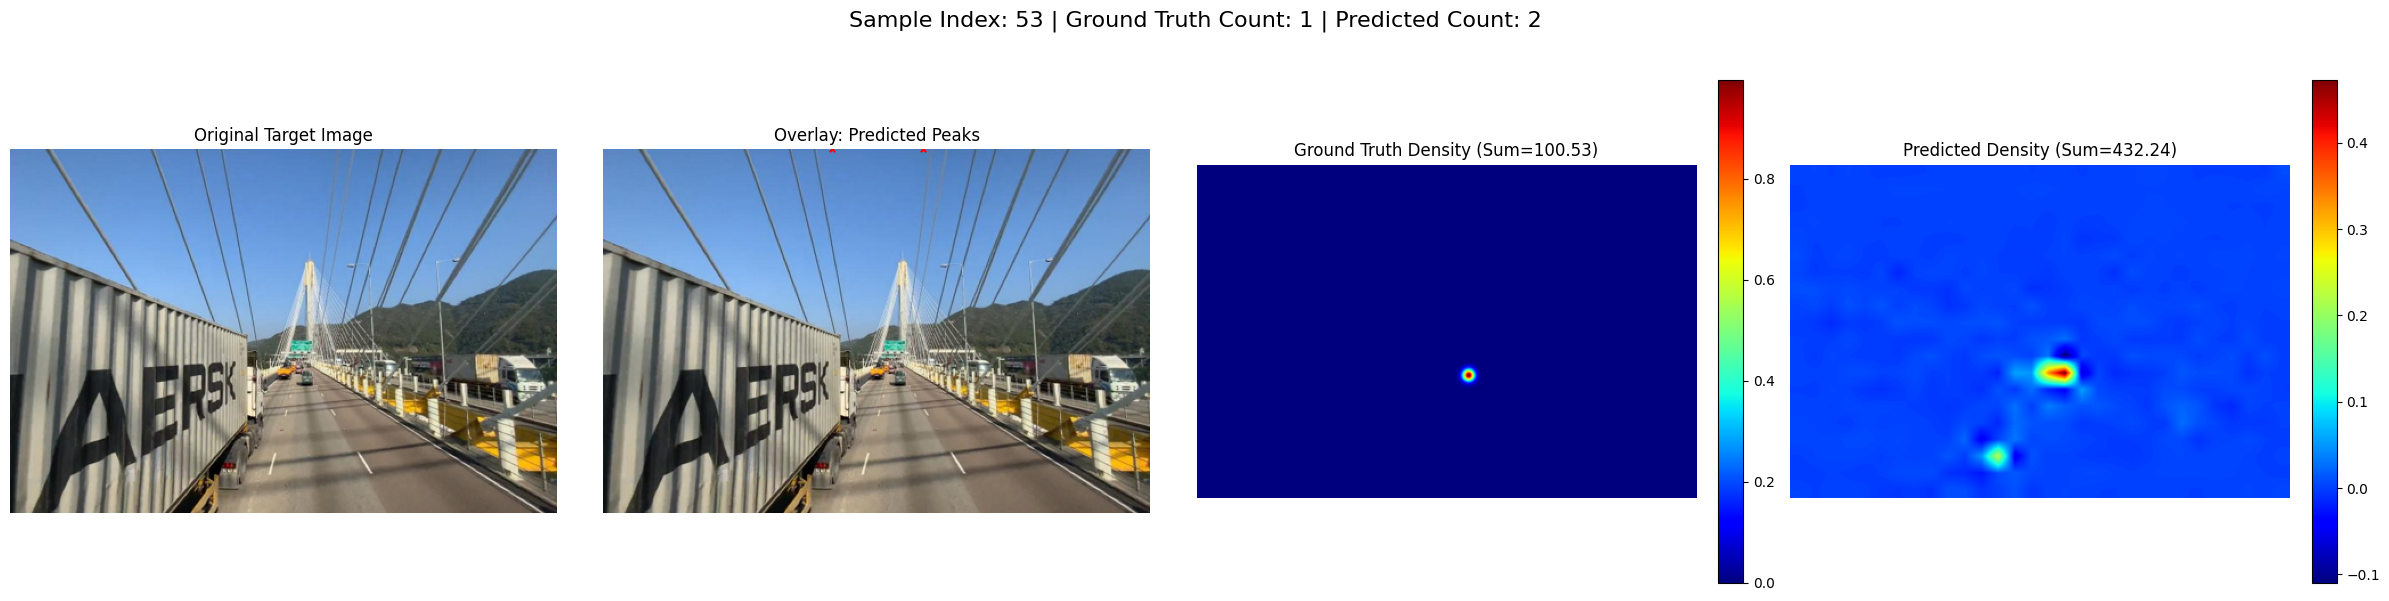

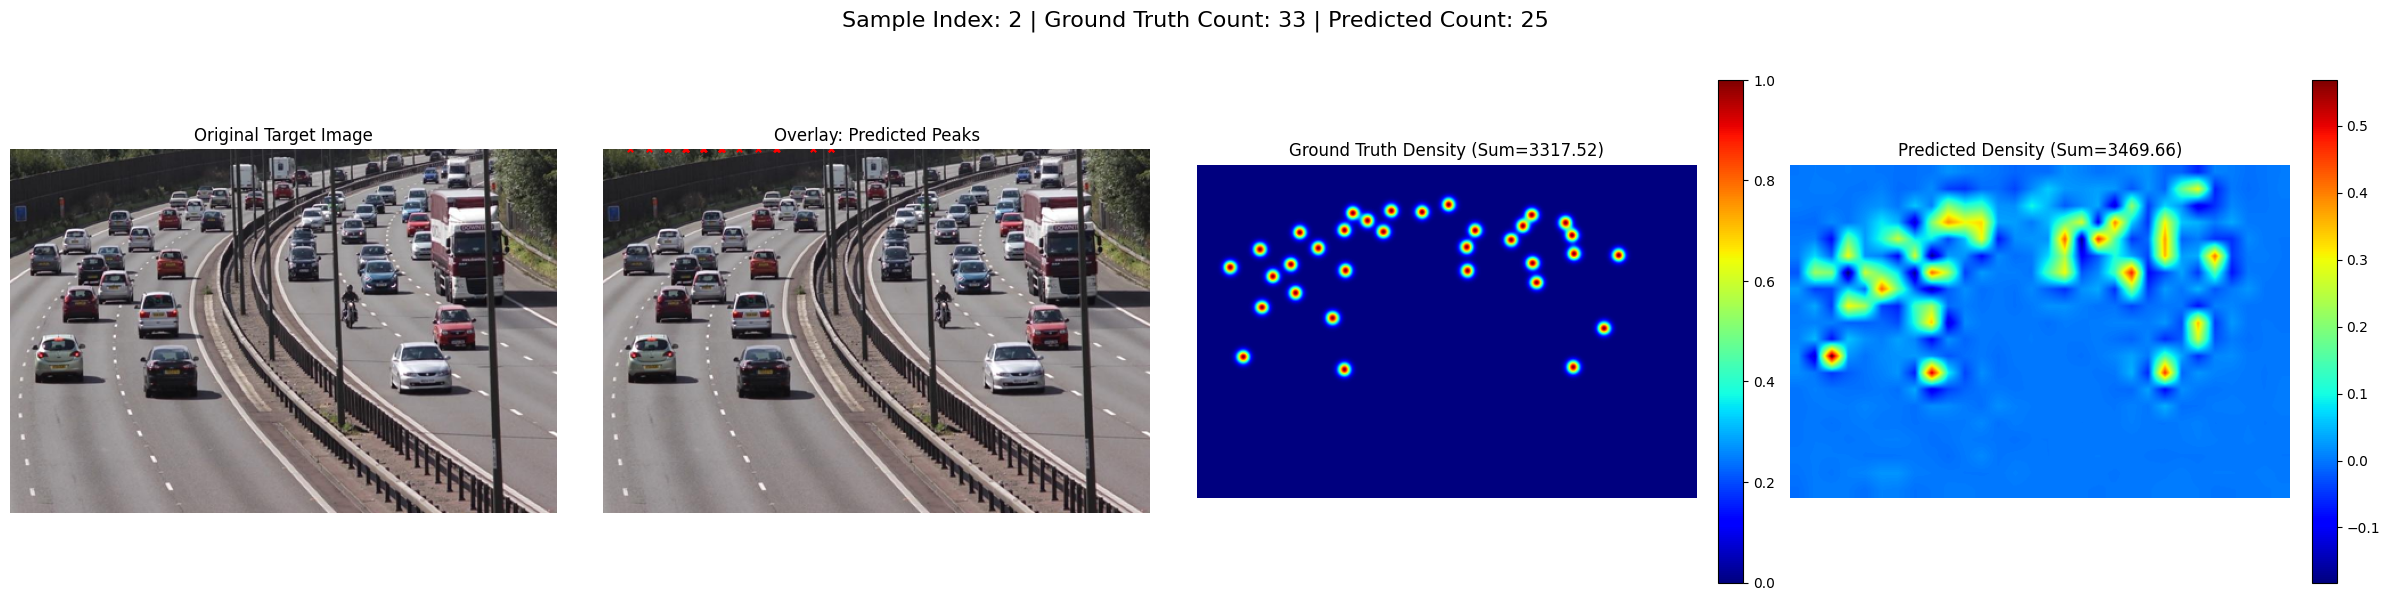

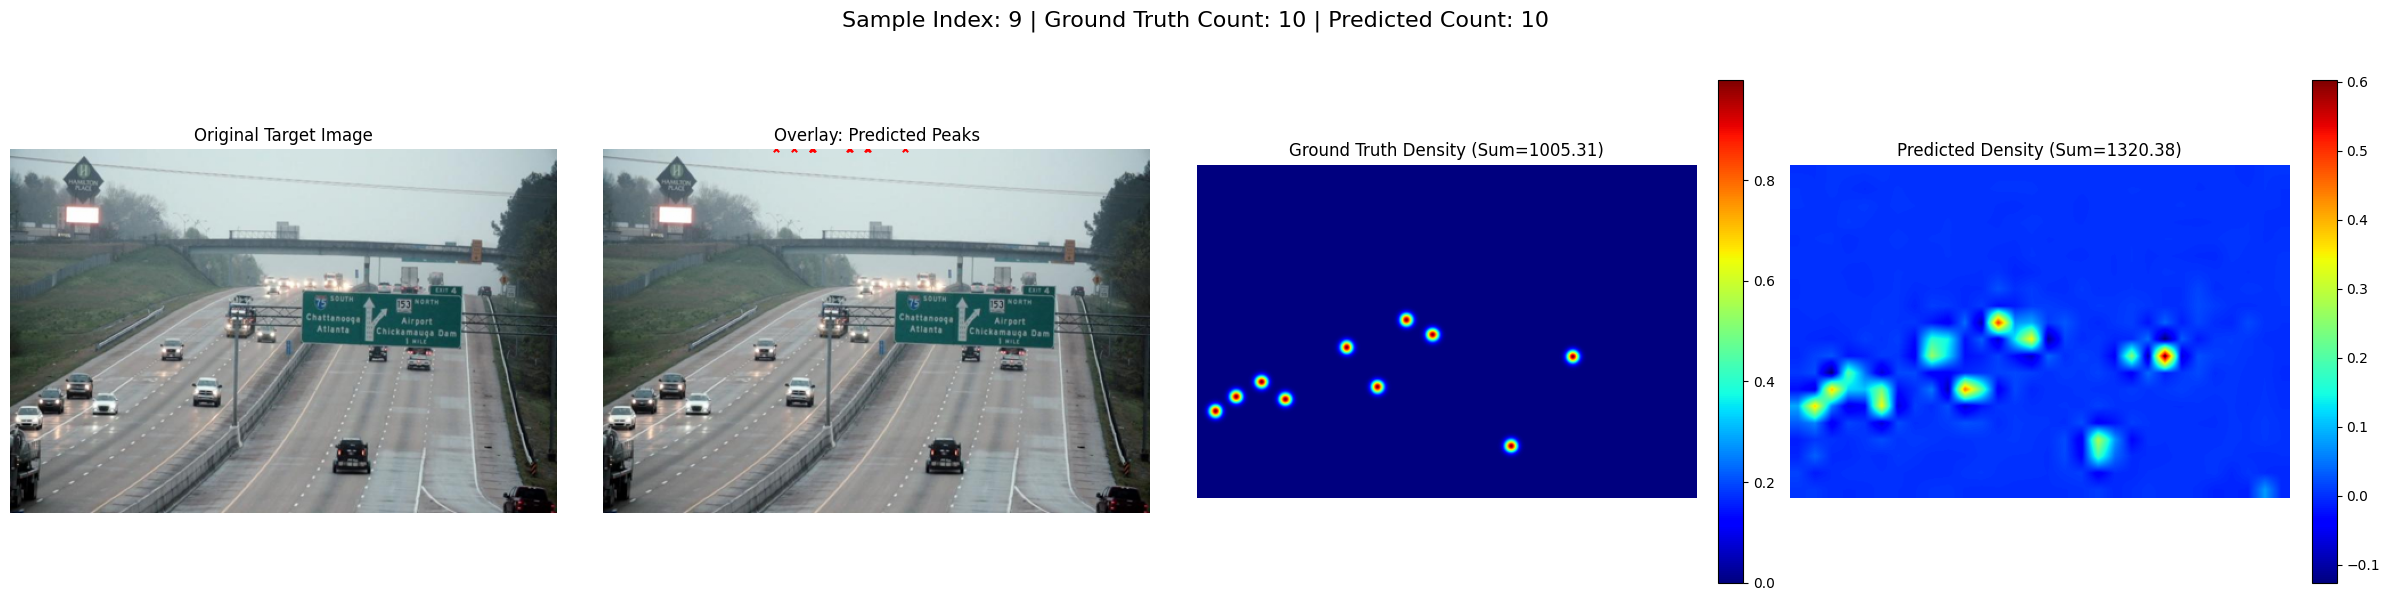

<Figure size 640x480 with 0 Axes>

In [13]:
%run visualize.py